# Synthesizing AIA Emission for NOAA 1158 (Region #2)

In [340]:
import os
import io
import glob
import warnings
import multiprocessing
import subprocess
import logging
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.DEBUG)

import numpy as np
from scipy.ndimage import gaussian_filter
from sunpy.map import Map
import yt
import h5py
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn.apionly as sns

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,UniformHeating
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

## Observational Data

In [2]:
hmi_map = Map('/data/datadrive1/ar_forward_modeling/systematic_ar_study/obs_data/hmi_m_45s_2011_02_12_15_33_45_tai_magnetogram.fits')

In [3]:
aia_171_map = Map('/data/datadrive1/ar_forward_modeling/systematic_ar_study/obs_data/aia_lev1_171a_2011_02_12t15_32_12_34z_image_lev1.fits')
aia_193_map = Map('/data/datadrive1/ar_forward_modeling/systematic_ar_study/obs_data/aia_lev1_193a_2011_02_12t15_32_09_63z_image_lev1.fits')

In [43]:
crop_range = (u.Quantity([-425,-165],u.arcsec),u.Quantity([-375,-100],u.arcsec))

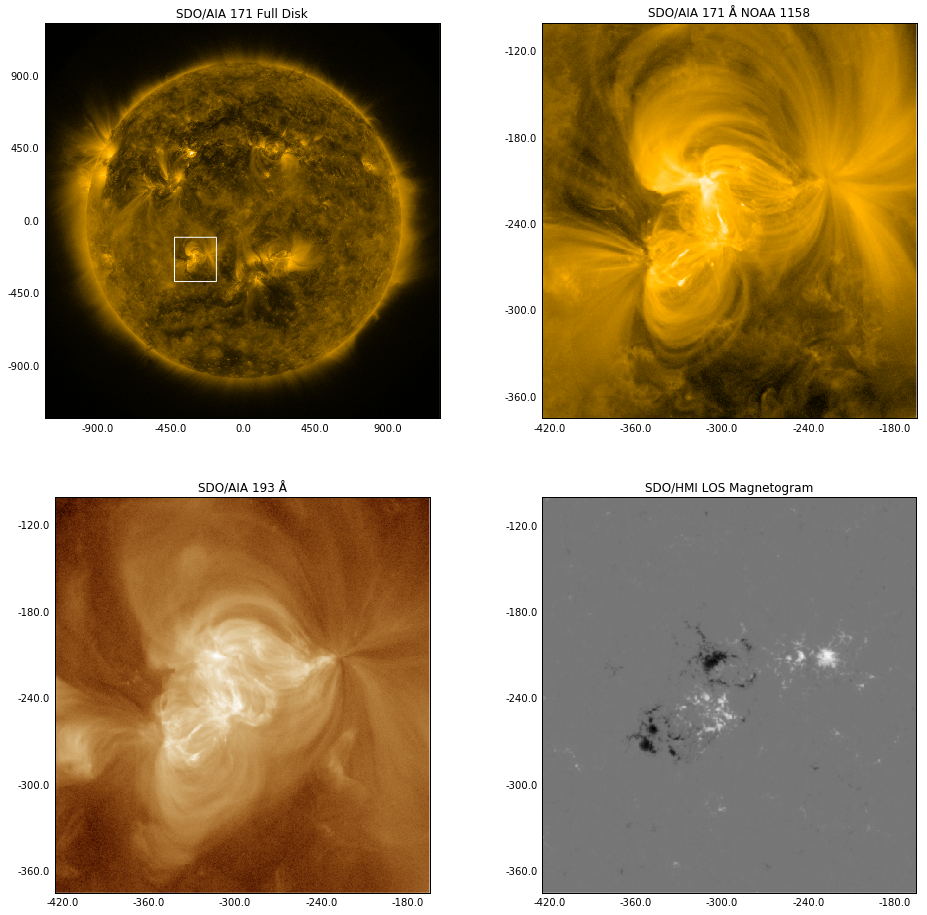

In [45]:
fig = plt.figure(figsize=(16,16))
## AIA
# 171
ax = fig.add_subplot(2,2,1,projection=aia_171_map)
aia_171_map.plot(annotate=False)
aia_171_map.draw_rectangle(u.Quantity([crop_range[0][0],crop_range[1][0]]),
                           np.diff(crop_range[0])[0],np.diff(crop_range[1])[0])
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'SDO/AIA 171 Full Disk')
aia_171_submap = aia_171_map.submap(*crop_range)
ax = fig.add_subplot(2,2,2,projection=aia_171_submap)
aia_171_submap.plot(annotate=False)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'SDO/AIA 171 Å NOAA 1158')
#193
aia_193_submap = aia_193_map.submap(*crop_range)
ax = fig.add_subplot(2,2,3,projection=aia_193_submap)
aia_193_submap.plot(annotate=False)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'SDO/AIA 193 Å')
## HMI
hmi_submap = hmi_map.rotate().submap(*crop_range)
ax = fig.add_subplot(2,2,4,projection=hmi_submap)
hmi_submap.plot(annotate=False)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'SDO/HMI LOS Magnetogram')

In [367]:
hmi_map.meta

MapMeta([('xtension', 'IMAGE'),
         ('bitpix', 32),
         ('naxis', 2),
         ('naxis1', 4096),
         ('naxis2', 4096),
         ('pcount', 0),
         ('gcount', 1),
         ('date', '2012-09-05T08:08:35'),
         ('date-obs', '2011-02-12T15:32:42.00'),
         ('telescop', 'SDO/HMI'),
         ('instrume', 'HMI_FRONT2'),
         ('wavelnth', 6173.0),
         ('camera', 2),
         ('bunit', 'Gauss'),
         ('origin', 'SDO/JSOC-SDP'),
         ('content', 'MAGNETOGRAM'),
         ('quality', 0),
         ('quallev1', 0),
         ('history',
          'Polynomial Coefficients used for Doppler velocity correction: 1.334407e+02 4.811302e-03 -1.356958e-06 3.275654e-10CROTA2 corrected by adding -0.0702 degrees'),
         ('comment',
          'De-rotation: ON; Un-distortion: ON; Re-centering: ON; Re-sizing: OFF; RSUNerr=0.5; correction for cosmic-ray hits'),
         ('bld_vers', '-512'),
         ('hcamid', 3),
         ('source',
          'hmi.lev1[:#15586048,

## Field Extrapolation
We've selected AR NOAA 1158, region #2 from Warren et al. (2011), to forward model using our field extrapolation and field-aligned hydrodynamics technique. First, we'll load in the HMI magnetogram, build the `Skeleton` object, extrapolate the field, and create the loops from our fieldline traces.

In [46]:
field = synthesizAR.Skeleton(hmi_fits_file='/data/datadrive1/ar_forward_modeling/systematic_ar_study/obs_data/hmi_m_45s_2011_02_12_15_33_45_tai_magnetogram.fits',
                             crop=crop_range,resample=u.Quantity([100,100],u.pixel))

In [47]:
zshape = 100
zrange = u.Quantity([0,max(np.diff(crop_range))],u.arcsec)

In [48]:
field.extrapolate_field(zshape=zshape,zrange=zrange)

True


yt : [INFO     ] 2017-08-04 12:10:59,191 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-08-04 12:10:59,191 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-08-04 12:10:59,192 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-08-04 12:10:59,193 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-08-04 12:10:59,194 Parameters: cosmological_simulation   = 0.0


In [80]:
field.extract_streamlines(10000,loop_length_range=[1e9,2e10]*u.cm,close_threshold=0.05)

yt : [INFO     ] 2017-08-04 13:19:53,686 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 10000/10000 [00:25<00:00, 396.94it/s]
yt : [INFO     ] 2017-08-04 13:20:29,629 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 3768/3768 [00:09<00:00, 394.90it/s]
yt : [INFO     ] 2017-08-04 13:20:42,987 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 1421/1421 [00:03<00:00, 387.74it/s]
yt : [INFO     ] 2017-08-04 13:20:48,236 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 531/531 [00:01<00:00, 403.91it/s]
yt : [INFO     ] 2017-08-04 13:20:50,374 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 189/189 [00:00<00:00, 370.93it/s]
yt : [INFO     ] 2017-08-04 13:20:51,359 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 78/78 [00:00<00:00, 365.80it/s]
yt : [INFO     ] 2017-08-04 13:20:51,948 AMRKDTree rebuilt, Final Volume: 6.279785

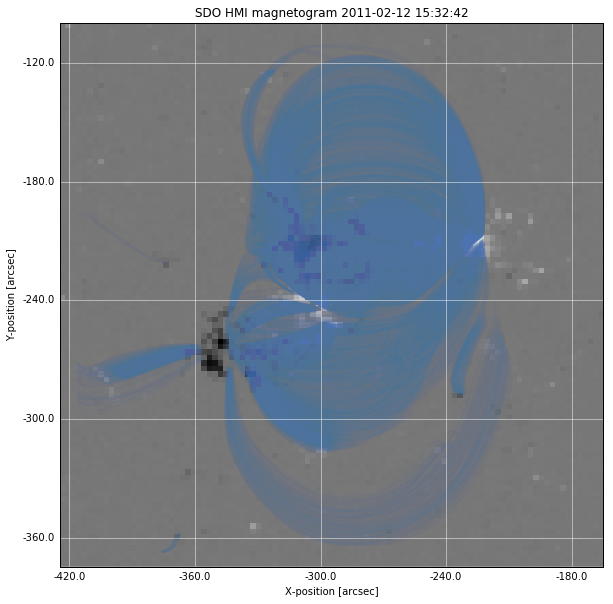

In [104]:
field.peek(alpha=0.05,color=sns.color_palette('deep')[0])

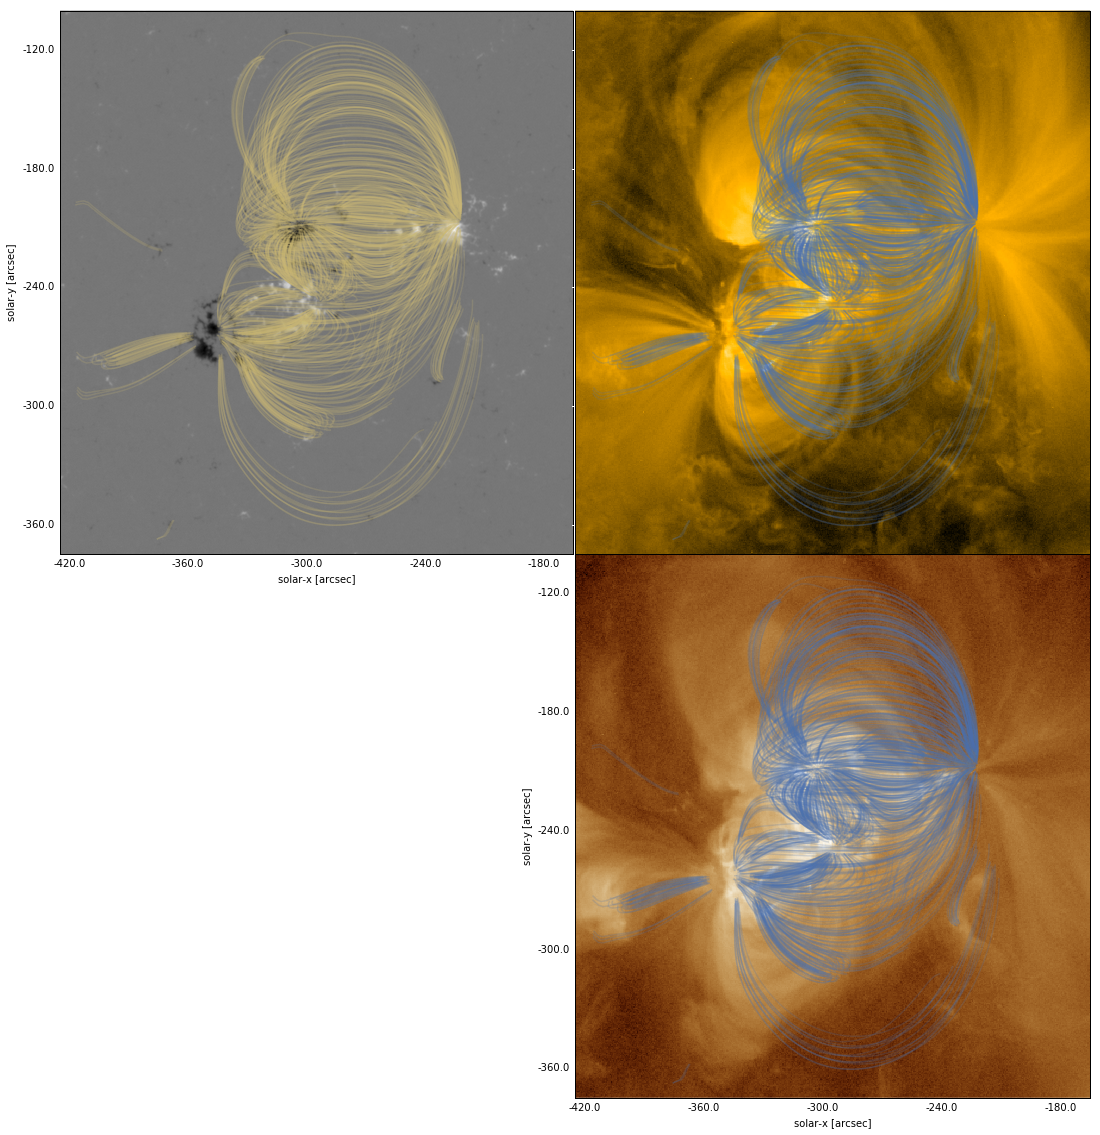

In [116]:
fig = plt.figure(figsize=(18.5,20))
plt.subplots_adjust(hspace=0.,wspace=0.)
## HMI
hmi_submap = hmi_map.rotate().submap(*crop_range)
axhmi = fig.add_subplot(2,2,1,projection=hmi_submap)
hmi_submap.plot(annotate=False)
axhmi.coords[0].grid(alpha=0)
axhmi.coords[1].grid(alpha=0)
#axhmi.coords[0].set_ticklabel_visible(False)
axhmi.set_xlabel(r'solar-x [arcsec]')
axhmi.set_ylabel(r'solar-y [arcsec]')
#axhmi.set_title(r'SDO/HMI')
## AIA
# 171
aia_171_submap = aia_171_map.submap(*crop_range)
ax171 = fig.add_subplot(2,2,2,projection=aia_171_submap)
aia_171_submap.plot(annotate=False)
ax171.coords[0].grid(alpha=0)
ax171.coords[1].grid(alpha=0)
#ax171.set_title('NOAA 1158\nSDO/AIA 171 Å')
ax171.coords[1].set_ticklabel_visible(False)
ax171.coords[0].set_ticklabel_visible(False)
#ax171.set_xlabel(r'solar-x [arcsec]')
#193
aia_193_submap = aia_193_map.submap(*crop_range)
ax193 = fig.add_subplot(2,2,4,projection=aia_193_submap)
aia_193_submap.plot(annotate=False)
ax193.coords[0].grid(alpha=0)
ax193.coords[1].grid(alpha=0)
#ax193.set_title(r'SDO/AIA 193 Å')
ax193.set_xlabel(r'solar-x [arcsec]')
ax193.set_ylabel(r'solar-y [arcsec]')
alpha=0.2
for stream, _ in field.streamlines[::10]:
    axhmi.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
               field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
               alpha=alpha,color=sns.color_palette('deep')[4],
               transform=axhmi.get_transform('world'))
    ax171.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
               field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
               alpha=alpha,color=sns.color_palette('deep')[0],
               transform=ax171.get_transform('world'))
    ax193.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
               field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
               alpha=alpha,color=sns.color_palette('deep')[0],
               transform=ax193.get_transform('world'))

In [117]:
field.make_loops()

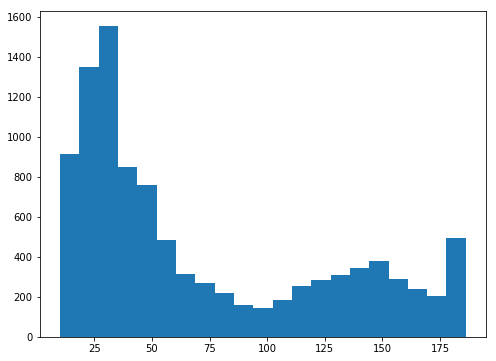

In [127]:
plt.figure(figsize=(8,6))
plt.hist([loop.full_length.to(u.Mm).value for loop in field.loops],bins='auto');

## Loop Hydrodynamics
For this simple test, we're just going to use a single 200 s heating pulse whose energy is constrained by the average field strength. We'll allow the loop to evolve for 5000 s.

First, configure the heating and setup all of the simulations.

In [ ]:
heating_options = {
    'duration':200,
    'average_waiting_time':4800,
    'duration_rise':100,
    'duration_decay':100,
    'stress_level':0.1
}
heating_model = UniformHeating(heating_options)

In [ ]:
ih = synthesizAR.util.InputHandler('/home/wtb2/Documents/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6

In [133]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/hydro_config',
                                 '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/hydro_results')

In [134]:
field.configure_loop_simulations(ebtel_interface)

Now, run the ebtel++ simulations. We'll use the multiprocessing pool to make use of all of our processors.

In [136]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [137]:
pool = multiprocessing.Pool()

In [138]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

Finally, load the results back into our field class.

In [139]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/loop_params.h5')

And save the field

In [140]:
field.save(savedir='/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/field_checkpoint')

Let's look at the loop simulations.

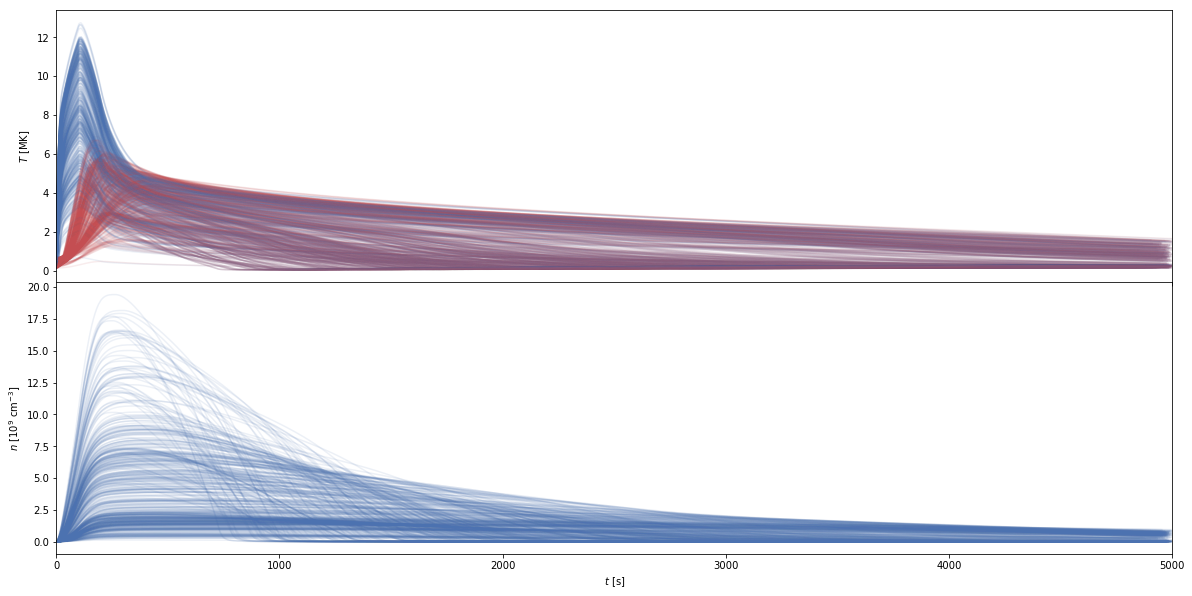

In [154]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::20]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color=sns.color_palette('deep')[0],alpha=0.1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color=sns.color_palette('deep')[2],alpha=0.1)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color=sns.color_palette('deep')[0],alpha=0.1)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

## Instrument Intensity Synthesis
Now, we want to synthesize the intensity in each of the AIA light curves. We'll just use the temperature response functions for now rather than the whole CHIANTI+NEI treatment.

In [172]:
aia = InstrumentSDOAIA([0,5000]*u.s)

In [ ]:
observer = synthesizAR.Observer(field,[aia],ds=field._convert_angle_to_length(1.2*u.arcsec))

In [174]:
observer.build_detector_files('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/')

INFO:InstrumentSDOAIA:Creating instrument file /data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/SDO_AIA_counts.h5


In [ ]:
observer.flatten_detector_counts()

INFO:Observer:Flattening counts for SDO_AIA
DEBUG:Observer:Flattening counts for loop0
DEBUG:Observer:Flattening counts for loop1
DEBUG:Observer:Flattening counts for loop2
DEBUG:Observer:Flattening counts for loop3
DEBUG:Observer:Flattening counts for loop4
DEBUG:Observer:Flattening counts for loop5
DEBUG:Observer:Flattening counts for loop6
DEBUG:Observer:Flattening counts for loop7
DEBUG:Observer:Flattening counts for loop8
DEBUG:Observer:Flattening counts for loop9
DEBUG:Observer:Flattening counts for loop10
DEBUG:Observer:Flattening counts for loop11
DEBUG:Observer:Flattening counts for loop12
DEBUG:Observer:Flattening counts for loop13
DEBUG:Observer:Flattening counts for loop14
DEBUG:Observer:Flattening counts for loop15
DEBUG:Observer:Flattening counts for loop16
DEBUG:Observer:Flattening counts for loop17
DEBUG:Observer:Flattening counts for loop18
DEBUG:Observer:Flattening counts for loop19
DEBUG:Observer:Flattening counts for loop20
DEBUG:Observer:Flattening counts for loop2

In [373]:
observer.bin_detector_counts('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/')

INFO:Observer:Building data products for SDO_AIA
DEBUG:Observer:Building data products at time 0.000 s
DEBUG:Observer:Building data products at time 10.000 s
DEBUG:Observer:Building data products at time 20.000 s
DEBUG:Observer:Building data products at time 30.000 s
DEBUG:Observer:Building data products at time 40.000 s
DEBUG:Observer:Building data products at time 50.000 s
DEBUG:Observer:Building data products at time 60.000 s
DEBUG:Observer:Building data products at time 70.000 s
DEBUG:Observer:Building data products at time 80.000 s
DEBUG:Observer:Building data products at time 90.000 s
DEBUG:Observer:Building data products at time 100.000 s
DEBUG:Observer:Building data products at time 110.000 s
DEBUG:Observer:Building data products at time 120.000 s
DEBUG:Observer:Building data products at time 130.000 s
DEBUG:Observer:Building data products at time 140.000 s
DEBUG:Observer:Building data products at time 150.000 s
DEBUG:Observer:Building data products at time 160.000 s
DEBUG:Obse

Finally, save the field object after we've computed all the needed maps so we can reload it later.

In [374]:
field.save('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/field_checkpoint/')

## Visualization

In [1]:
def make_em_frame(obs_time):
    fig = plt.figure(figsize=(14.25,15))
    plt.subplots_adjust(wspace=0.,hspace=0.,top=0.95,right=0.945)
    cax = fig.add_axes([0.95,0.13,0.02,0.815])
    em_map = observer.make_emission_measure_map(obs_time,aia,temperature_bin_edges = np.logspace(5,7.1,10)*u.K)
    for i,emap in enumerate(em_map):
        ax = fig.add_subplot(3,3,i+1,projection=emap)
        emap.data = gaussian_filter(emap.data,(aia.channels[3]['gaussian_width']['y'].value,
                                               aia.channels[3]['gaussian_width']['x'].value))
        im = emap.plot(annotate=False,
                       norm=matplotlib.colors.SymLogNorm(10,vmin=1e25,vmax=1e29),
                       cmap=plt.get_cmap('magma')
                      )
        if i%3 == 0:
            ax.set_ylabel('solar-y [arcsec]')
        else:
            ax.coords[1].set_ticklabel_visible(False)
        if i>5:
            ax.set_xlabel('solar-y [arcsec]')
        else:
            ax.coords[0].set_ticklabel_visible(False)
        xtext,ytext = emap.data_to_pixel(-340*u.arcsec,-340*u.arcsec)
        ax.text(xtext.value,ytext.value,
                r'{:.2f}-{:.2f} MK'.format(emap.meta['temp_a']/1e6,emap.meta['temp_b']/1e6),
                color='w',fontsize=14
               )
        ax.coords[0].grid(alpha=0)
        ax.coords[1].grid(alpha=0)
        ax.coords[0].set_ticks_visible(False)
        ax.coords[1].set_ticks_visible(False)
    fig.suptitle(r'$t={}$ s'.format(obs_time.value),fontsize=18)
    fig.colorbar(im,cax=cax)
    figdir = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/figures/em/'
    #fig.savefig(os.path.join(figdir,'em_map_t{:06d}.png'.format(np.where(aia.observing_time==obs_time)[0][0])),
    #            bbox_inches='tight',format='png')
    #fig.clf()

In [365]:
for aia_obs_time in aia.observing_time:
    print(aia_obs_time)
    make_em_frame(aia_obs_time)

0.0 s
10.0 s
20.0 s
30.0 s
40.0 s
50.0 s
60.0 s
70.0 s
80.0 s
90.0 s
100.0 s
110.0 s
120.0 s
130.0 s
140.0 s
150.0 s
160.0 s
170.0 s
180.0 s
190.0 s
200.0 s
210.0 s
220.0 s
230.0 s
240.0 s
250.0 s
260.0 s
270.0 s
280.0 s
290.0 s
300.0 s
310.0 s
320.0 s
330.0 s
340.0 s
350.0 s
360.0 s
370.0 s
380.0 s
390.0 s
400.0 s
410.0 s
420.0 s
430.0 s
440.0 s
450.0 s
460.0 s
470.0 s
480.0 s
490.0 s
500.0 s
510.0 s
520.0 s
530.0 s
540.0 s
550.0 s
560.0 s
570.0 s
580.0 s
590.0 s
600.0 s
610.0 s
620.0 s
630.0 s
640.0 s
650.0 s
660.0 s
670.0 s
680.0 s
690.0 s
700.0 s
710.0 s
720.0 s
730.0 s
740.0 s
750.0 s
760.0 s
770.0 s
780.0 s
790.0 s
800.0 s
810.0 s
820.0 s
830.0 s
840.0 s
850.0 s
860.0 s
870.0 s
880.0 s
890.0 s
900.0 s
910.0 s
920.0 s
930.0 s
940.0 s
950.0 s
960.0 s
970.0 s
980.0 s
990.0 s
1000.0 s
1010.0 s
1020.0 s
1030.0 s
1040.0 s
1050.0 s
1060.0 s
1070.0 s
1080.0 s
1090.0 s
1100.0 s
1110.0 s
1120.0 s
1130.0 s
1140.0 s
1150.0 s
1160.0 s
1170.0 s
1180.0 s
1190.0 s
1200.0 s
1210.0 s
1220.0 s
1230

In [366]:
%%bash
convert -delay 5 -loop 0  /data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/figures/em/*.png em_evolution.gif

In [371]:
em_map = observer.make_emission_measure_map(2000*u.s,aia,
                                            temperature_bin_edges = np.logspace(5.1,7.1,10)*u.K)

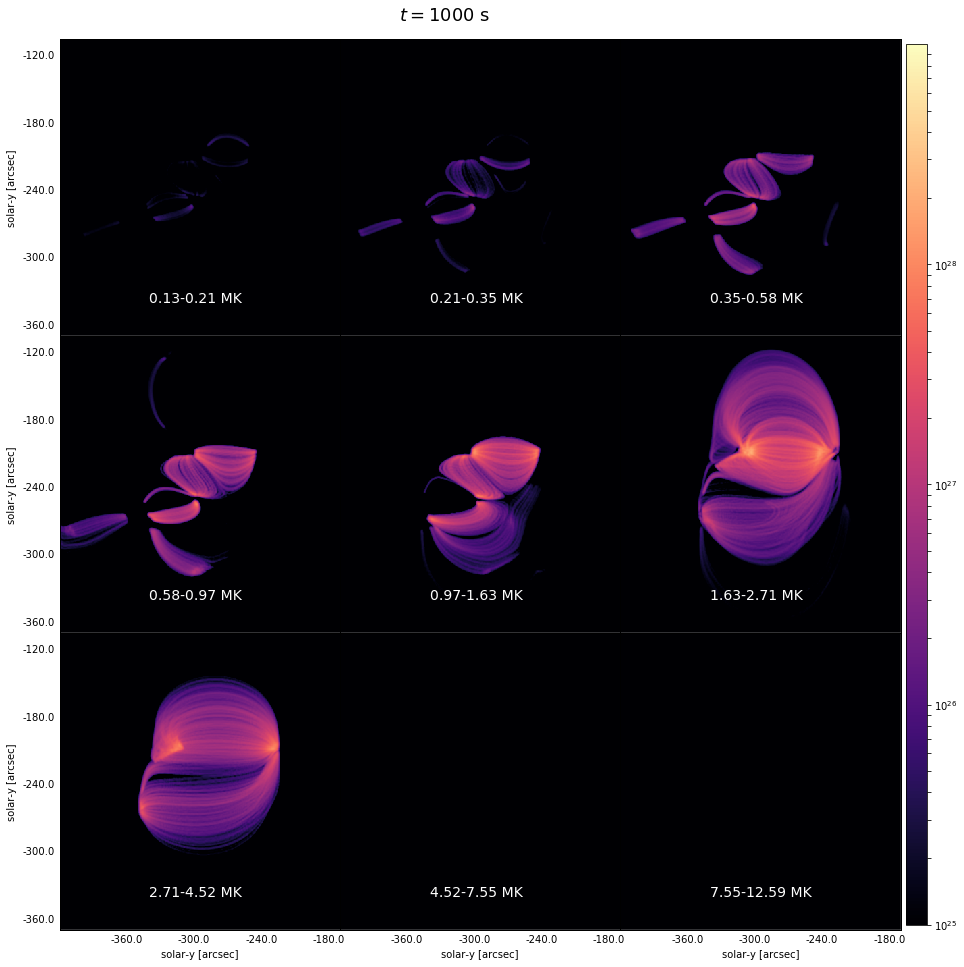

In [372]:
fig = plt.figure(figsize=(14.25,15))
plt.subplots_adjust(wspace=0.,hspace=0.,top=0.95,right=0.945)
cax = fig.add_axes([0.95,0.13,0.02,0.815])
for i,emap in enumerate(em_map):
    ax = fig.add_subplot(3,3,i+1,projection=emap)
    emap.data = gaussian_filter(emap.data,(aia.channels[1]['gaussian_width']['y'].value,
                                           aia.channels[1]['gaussian_width']['x'].value))
    im = emap.plot(annotate=False,
                   norm=matplotlib.colors.SymLogNorm(10,vmin=1e25,vmax=1e29),
                   cmap=plt.get_cmap('magma')
                  )
    if i%3 == 0:
        ax.set_ylabel('solar-y [arcsec]')
    else:
        ax.coords[1].set_ticklabel_visible(False)
    if i>5:
        ax.set_xlabel('solar-y [arcsec]')
    else:
        ax.coords[0].set_ticklabel_visible(False)
    xtext,ytext = emap.data_to_pixel(-340*u.arcsec,-340*u.arcsec)
    ax.text(xtext.value,ytext.value,
            r'{:.2f}-{:.2f} MK'.format(emap.meta['temp_a']/1e6,emap.meta['temp_b']/1e6),
            color='w',fontsize=14
           )
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)
fig.suptitle(r'$t={}$ s'.format(1000),fontsize=18)
fig.colorbar(im,cax=cax)

In [2]:
make_em_frame(100*u.s)

NameError: name 'u' is not defined

In [400]:
def make_aia_frame(obs_time,save=False):
    obs_time_index = np.where(aia.observing_time==obs_time)[0][0]
    fn_prefix = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/'
    fig = plt.figure(figsize=(15,10))
    plt.subplots_adjust(wspace=0.,hspace=0.,top=0.95)
    for i,chan in enumerate(aia.channels):
        tmp = Map(os.path.join(fn_prefix,
                               'SDO_AIA/{}/map_t{:06d}.fits'.format(chan['name'],obs_time_index)))
        #tmp = tmp.submap(u.Quantity((-75,75),u.arcsec),
        #                 u.Quantity((-100,100),u.arcsec))
        ax = fig.add_subplot(2,3,i+1,projection=tmp)
        tmp.plot(annotate=False,
                 norm=matplotlib.colors.SymLogNorm(0.1,vmin=1,vmax=5e4))
        ax.coords[0].grid(alpha=0)
        ax.coords[1].grid(alpha=0)
        ax.coords[0].set_ticks_visible(False)
        ax.coords[1].set_ticks_visible(False)
        if i%3==0:
            ax.set_ylabel(r'solar-y [arcsec]',fontsize=14)
        else:
            ax.coords[1].set_ticklabel_visible(False)
        if i>2:
            ax.set_xlabel(r'solar-x [arcsec]',fontsize=14)
        else:
            ax.coords[0].set_ticklabel_visible(False)
        xtext,ytext = emap.data_to_pixel(-230*u.arcsec,-130*u.arcsec)
        ax.text(xtext.value,ytext.value,
                r'${}$ $\mathrm{{\mathring{{A}}}}$'.format(chan['name']),color='w',fontsize=16)
    fig.suptitle(r'$t={:.0f}$ s'.format(obs_time.value),fontsize=14)
    if save:
        figdir = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/figures/aia/'
        fig.savefig(os.path.join(figdir,'all_channels_map_t{:06d}.png'.format(obs_time_index)),format='png',
                    bbox_inches='tight')
        fig.clf()

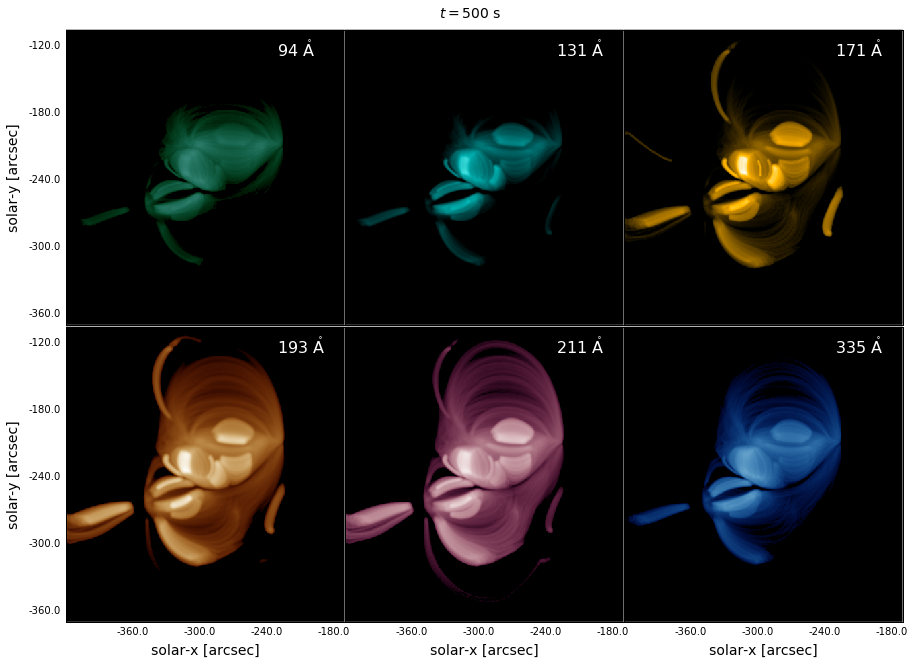

In [401]:
make_aia_frame(500*u.s)

In [402]:
for t in aia.observing_time:
    print(t)
    make_aia_frame(t,save=True)

0.0 s
10.0 s
20.0 s
30.0 s
40.0 s
50.0 s
60.0 s
70.0 s
80.0 s
90.0 s
100.0 s
110.0 s
120.0 s
130.0 s
140.0 s
150.0 s
160.0 s
170.0 s
180.0 s
190.0 s
200.0 s
210.0 s
220.0 s
230.0 s
240.0 s
250.0 s
260.0 s
270.0 s
280.0 s
290.0 s
300.0 s
310.0 s
320.0 s
330.0 s
340.0 s
350.0 s
360.0 s
370.0 s
380.0 s
390.0 s
400.0 s
410.0 s
420.0 s
430.0 s
440.0 s
450.0 s
460.0 s
470.0 s
480.0 s
490.0 s
500.0 s
510.0 s
520.0 s
530.0 s
540.0 s
550.0 s
560.0 s
570.0 s
580.0 s
590.0 s
600.0 s
610.0 s
620.0 s
630.0 s
640.0 s
650.0 s
660.0 s
670.0 s
680.0 s
690.0 s
700.0 s
710.0 s
720.0 s
730.0 s
740.0 s
750.0 s
760.0 s
770.0 s
780.0 s
790.0 s
800.0 s
810.0 s
820.0 s
830.0 s
840.0 s
850.0 s
860.0 s
870.0 s
880.0 s
890.0 s
900.0 s
910.0 s
920.0 s
930.0 s
940.0 s
950.0 s
960.0 s
970.0 s
980.0 s
990.0 s
1000.0 s
1010.0 s
1020.0 s
1030.0 s
1040.0 s
1050.0 s
1060.0 s
1070.0 s
1080.0 s
1090.0 s
1100.0 s
1110.0 s
1120.0 s
1130.0 s
1140.0 s
1150.0 s
1160.0 s
1170.0 s
1180.0 s
1190.0 s
1200.0 s
1210.0 s
1220.0 s
1230

In [403]:
%%bash
convert -delay 5 -loop 0  /data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/figures/aia/*.png aia_evolution.gif